# Compare models to predict OD reports
Predicting Fentanyl overdoses based on darknet data


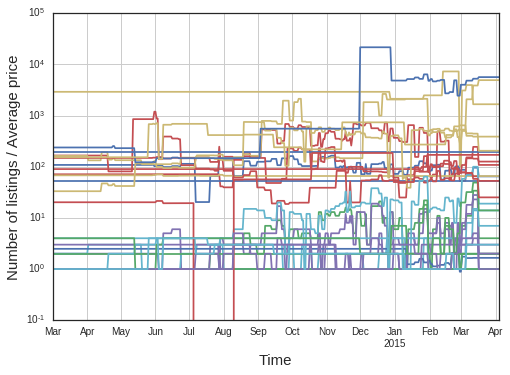

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# Seaborn figures with matplotlib color codes mapped to the default seaborn palette 
import seaborn as sns
sns.set(style="white", color_codes=True)

#models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import cross_validation
from sklearn.cross_validation import train_test_split

# load feature matrix and label data
X = pd.read_pickle('./data/Fentanyl_Feature_X.pkl')
y = pd.read_pickle('./data/GNreports_y.pkl')
# fill NaN's with nearest values
X = X.fillna(method='backfill',axis=0)
X = X.fillna(method='pad',axis=0)

# plot all features
fig = plt.figure(2)
X.plot(legend=False)
plt.xlabel("Time",fontsize=15)
plt.ylabel("Number of listings / Average price",fontsize=15)
plt.grid(True)
plt.yscale('log')
plt.show()


## Quick and simple Random Forest model


In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25, random_state=123)

# Create Random Forest object
model= RandomForestClassifier(n_estimators=200)
# Train the model using the training sets and check score
model.fit(X_train,y_train)
# Predict Output
y_predicted = model.predict(X_test)

n_samples = X.shape[0]
cv = cross_validation.ShuffleSplit(n_samples, n_iter=4, test_size=0.25, random_state=777)
crossValScore = cross_validation.cross_val_score(model, X, y, cv=cv)

p1 = float(sum(y_train == 1))/len(y_train)*100
p0 = float(sum(y_train == 0))/len(y_train)*100
p_1 = float(sum(y_train == -1))/len(y_train)*100
print 'Imbalanced model'
print 'Class balance: %d%% / %d%% / %d%%' % (p1,p0,p_1)
print 'Training/Test Ratio: '+str(X_train.shape[0] / X_test.shape[0])
print 'Classifier score='+str(model.score(X_test, y_test))
print 'Cross-validation score='+str(crossValScore)
pd.crosstab(y_test, y_predicted, rownames=['actual'], colnames=['preds'])

Imbalanced model
Class balance: 14% / 78% / 7%
Training/Test Ratio: 3
Classifier score=0.88
Cross-validation score=[ 0.91  0.89  0.88  0.9 ]


preds,-1,0,1
actual,,,
-1,5,3,0
0,1,75,2
1,0,6,8


## Class balance and correlation
Fix class imbalance by oversampling (SMOTE), investigate correlation by relative shifting the label in time

In [19]:
# Assign time shifted labels 
shift = 10 #in days
X_shifted = X.head(X.shape[0]-shift)
y_shifted = y.tail(y.shape[0]-shift)

#split data
X_train, X_test, y_train, y_test = train_test_split(X_shifted, y_shifted, stratify=y_shifted, test_size=0.25, random_state=123)

## Fix class imbalance with SMOTE oversampling
from unbalanced_dataset.over_sampling import RandomOverSampler
from unbalanced_dataset.over_sampling import SMOTE #Synthetic Minority Over-sampling Technique
smote = SMOTE(ratio='auto', verbose=False, kind='regular')
SMO_X_train_temp, SMO_y_train_temp = smote.fit_transform(X_train, y_train)
SMO_X_train, SMO_y_train = smote.fit_transform(SMO_X_train_temp, SMO_y_train_temp)

p1 = float(sum(SMO_y_train == 1))/len(SMO_y_train)*100
p0 = float(sum(SMO_y_train == 0))/len(SMO_y_train)*100
p_1 = float(sum(SMO_y_train == -1))/len(SMO_y_train)*100
print 'Balanced model'
print 'Class balance: %d%% / %d%% / %d%%' % (p1,p0,p_1)

Balanced model
Class balance: 33% / 33% / 33%


## Logistic regression

In [20]:
from sklearn import linear_model
model_logistic = linear_model.LogisticRegression(max_iter=10000)

model_logistic.fit(SMO_X_train, SMO_y_train)
y_predicted_logistic = model_logistic.predict(X_test)

from sklearn import cross_validation
cv = cross_validation.ShuffleSplit(len(y), n_iter=5, test_size=0.3, random_state=1)
crossValScore_logistic = cross_validation.cross_val_score(model_logistic, X, y, cv=cv)
print 'Training/Test Ratio: '+str(X_train.shape[0] / X_test.shape[0])
print 'Classifier score='+str(model_logistic.score(X_test, y_test))
print 'Cross-validation score='+str(crossValScore_logistic)
print("Accuracy: %0.2f (+/- %0.2f)" % (crossValScore_logistic.mean(), crossValScore_logistic.std() * 2))
pd.crosstab(y_test, y_predicted_logistic, rownames=['actual'], colnames=['preds'])

Training/Test Ratio: 2
Classifier score=0.612244897959
Cross-validation score=[ 0.83333333  0.85        0.79166667  0.825       0.85      ]
Accuracy: 0.83 (+/- 0.04)


preds,-1,0,1
actual,,,
-1,7,1,0
0,21,43,12
1,0,4,10


## Random forest model
with balanced class and shifted labels

In [25]:
# Create Random Forest object
model= RandomForestClassifier(n_estimators=200)
# Train the model using the training sets and check score
model.fit(SMO_X_train,SMO_y_train)
# Predict Output
y_predicted = model.predict(X_test)

n_samples = X_shifted.shape[0]
cv = cross_validation.ShuffleSplit(n_samples, n_iter=4, test_size=0.25, random_state=777)
crossValScore = cross_validation.cross_val_score(model, X_shifted, y_shifted, cv=cv)

print 'Training/Test Ratio: '+str(X_train.shape[0] / X_test.shape[0])
print 'Classifier score='+str(model.score(X_test, y_test))
print 'Cross-validation score='+str(crossValScore)
pd.crosstab(y_test, y_predicted, rownames=['actual'], colnames=['preds'])

Training/Test Ratio: 2
Classifier score=0.897959183673
Cross-validation score=[ 0.81632653  0.89795918  0.89795918  0.89795918]


preds,-1,0,1
actual,,,
-1,6,2,0
0,5,70,1
1,0,2,12


## Confusion matrix and feature importance


Confusion matrix, without normalization
[[ 6  2  0]
 [ 5 70  1]
 [ 0  2 12]]
             precision    recall  f1-score   support

         -1       0.55      0.75      0.63         8
          0       0.95      0.92      0.93        76
          1       0.92      0.86      0.89        14

avg / total       0.91      0.90      0.90        98

Normalized confusion matrix
[[ 0.75  0.25  0.  ]
 [ 0.07  0.92  0.01]
 [ 0.    0.14  0.86]]


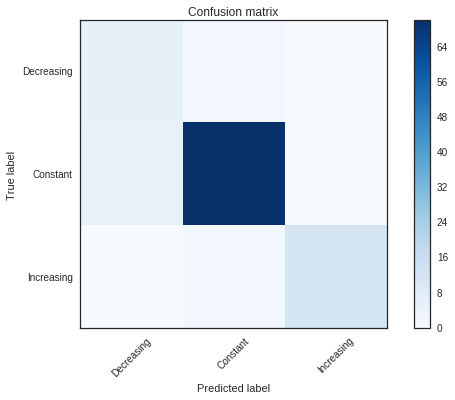

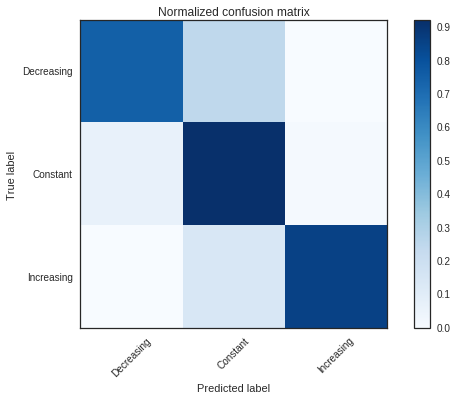

In [26]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = [0,1,2]
    plt.xticks(tick_marks, ['Decreasing', 'Constant', 'Increasing'], rotation=45)
    plt.yticks(tick_marks, ['Decreasing', 'Constant', 'Increasing'])
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

cm = confusion_matrix(y_test, y_predicted)
np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
print(cm)
print classification_report(y_test, y_predicted)
plt.figure()
plot_confusion_matrix(cm)

# Normalize the confusion matrix by the number of samples in each class
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
print(cm_normalized)
plt.figure()
plot_confusion_matrix(cm_normalized, title='Normalized confusion matrix')
plt.show()

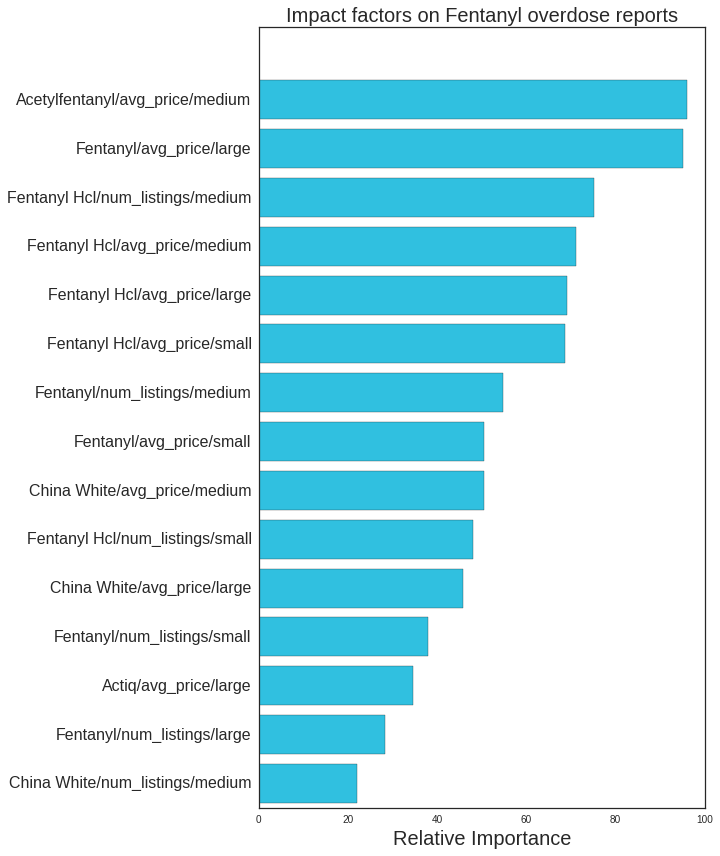

In [27]:
numBars = 15
Xlabel=X.columns
# Get Feature Importance from the classifier
feature_importance = model.feature_importances_
# Normalize The Features
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
# print pos[len(pos)-numBars-1:-1]
# print feature_importance[sorted_idx][len(pos)-11:-1]
plt.figure(figsize=(8, 14))
plt.barh(pos[len(pos)-numBars-1:-1], feature_importance[sorted_idx][len(pos)-numBars-1:-1], align='center', color='#30C0E0')
plt.yticks(pos[len(pos)-numBars-1:-1], np.asanyarray(Xlabel)[sorted_idx][len(pos)-numBars-1:-1],fontsize = 16)
plt.xlabel('Relative Importance',fontsize = 20)
plt.title('Impact factors on Fentanyl overdose reports',fontsize = 20)
plt.show()

## Pickle it

In [11]:
import pickle
with open('DNetModel.b', 'wb') as modelfile:
    pickle.dump(model, modelfile)